<a href="https://colab.research.google.com/github/HardikPrabhu/Natural-Language-Processing-on-the-Covid-19-Research-papers/blob/main/NLP_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP-Assignment 3**

Hardik Prabhu

MDS201912

We are going to take the preprocessed corpus (preprocesssing was done in the 1st assignment) and remove the stopwords and convert it into word2vec model input. 


In [ ]:
import pickle
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
location="/content/drive/MyDrive/pdf_json"  #location of json files
save_location="/content/drive/MyDrive"      #location on my gdrive
os.chdir(save_location)

In [ ]:
#remove stopwords

words=['this', 'is', 'a',"sentence"]  

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]
print(words)

['sentence']


Our corpus is a list of documents. A document is a list of sentences. A sentence is a list of words. 
We will remove out all the stopwords from the preprocessed corpus and then combine all the documents into single corpus. That is a list of list of words. (The input format for word2vec model)

In [ ]:
def preprocess(corpus):
  out=[]
  for document in corpus:
    for sentence in document:
      words = [w for w in sentence if not w in stop_words]
      if len(words)!=0:  
       out.append(words) 
  return out 



In [ ]:
corpus=[]
for m in range(16):
  print(m)
  with open("nlp-"+str(m), "rb") as f:
    corp=pickle.load(f)
 
  corpus=corpus+preprocess(corp) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [ ]:
corp=[]

In [ ]:
def compute_word_vectors(): 
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = Word2Vec(corpus, size=128, window=5, min_count=50, workers=10, iter=5)
    model.save('/content/drive/MyDrive/text9.model.bin')
    return model


In [ ]:
def compute_similar_words(model,source_word, topn=5):
    print('\r Computing similar words for the source word - {0}'.format(source_word),end='')
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word,topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)
    return similar_words  

In [ ]:
import pandas as pd
def compute_similar_words_for_assignment3(model): #model - Word2vec model stored earlier 
    columns = ['word'+str(i-1) for i in range(1,7)]
    df = pd.DataFrame(data=None,columns=columns)

    #Keywords contains the list of keywords from the vocabulary. 
    #These keywords are used to find similar words 
    keywords=['pharmaceutical','animal','vaccine','testing','mask','mortality','lungs','study','treatment','predictors']

    for source_word in keywords:                                                     # 4 levels deep similar words picking
        similar_words = compute_similar_words(model,source_word)
        df.loc[len(df)] = similar_words
        
        for i in range(1,len(similar_words)):
            sec_similar_words = compute_similar_words(model,similar_words[i])
            df.loc[len(df)] = sec_similar_words
            
            for i in range(1,len(sec_similar_words)):
              thi_similar_words = compute_similar_words(model,sec_similar_words[i])
              df.loc[len(df)] = thi_similar_words
               
              for i in range(1,len(thi_similar_words)):
                four_similar_words = compute_similar_words(model,thi_similar_words[i])
                df.loc[len(df)] = four_similar_words



    print(df)
   #Save similar words to a file. This file will be used to build the graph
    df.to_csv('/content/drive/MyDrive/similar_words_assignment3.csv')

In [ ]:
import logging
from gensim.models import Word2Vec

model = compute_word_vectors()
compute_similar_words_for_assignment3(model)


2021-04-19 23:07:59,824 : INFO : collecting all words and their counts
2021-04-19 23:07:59,827 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-19 23:07:59,874 : INFO : PROGRESS: at sentence #10000, processed 170830 words, keeping 17142 word types
2021-04-19 23:07:59,922 : INFO : PROGRESS: at sentence #20000, processed 345999 words, keeping 24529 word types
2021-04-19 23:07:59,973 : INFO : PROGRESS: at sentence #30000, processed 520520 words, keeping 30344 word types
2021-04-19 23:08:00,023 : INFO : PROGRESS: at sentence #40000, processed 682912 words, keeping 35046 word types
2021-04-19 23:08:00,074 : INFO : PROGRESS: at sentence #50000, processed 854763 words, keeping 39846 word types
2021-04-19 23:08:00,121 : INFO : PROGRESS: at sentence #60000, processed 1010117 words, keeping 43637 word types
2021-04-19 23:08:00,171 : INFO : PROGRESS: at sentence #70000, processed 1171924 words, keeping 47141 word types
2021-04-19 23:08:00,224 : INFO : PROGRESS: a

 Computing similar words for the source word - confounder                   word0               word1  ...              word4          word5
0         pharmaceutical   biopharmaceutical  ...       governmental     unapproved
1      biopharmaceutical  biopharmaceuticals  ...  commercialization  bioprocessing
2     biopharmaceuticals   biopharmaceutical  ...        manufacture  bioprocessing
3      biopharmaceutical  biopharmaceuticals  ...  commercialization  bioprocessing
4        biotherapeutics  biopharmaceuticals  ...          biopharma       patented
...                  ...                 ...  ...                ...            ...
1555          covariates           covariate  ...        covariables     confounder
1556           variables          covariates  ...           variable     attributes
1557         covariables          covariates  ...          variables  multivariable
1558              ancova              manova  ...      nonparametric          anova
1559          confo

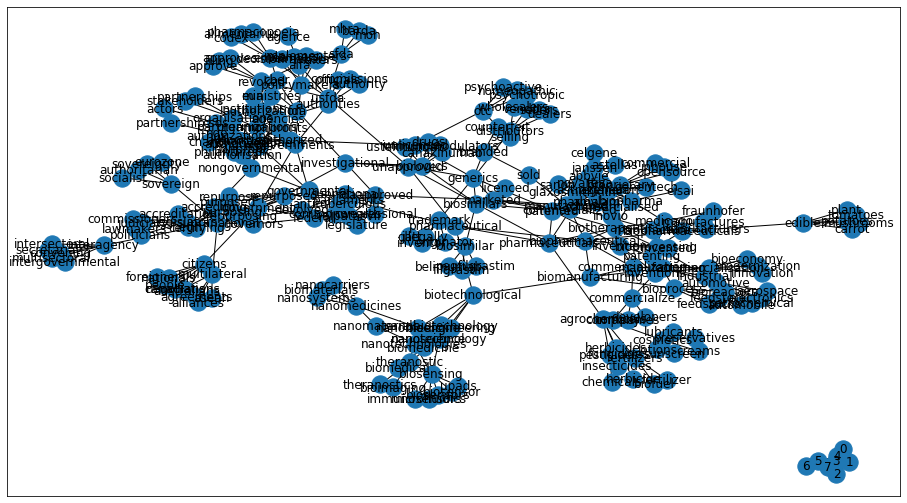

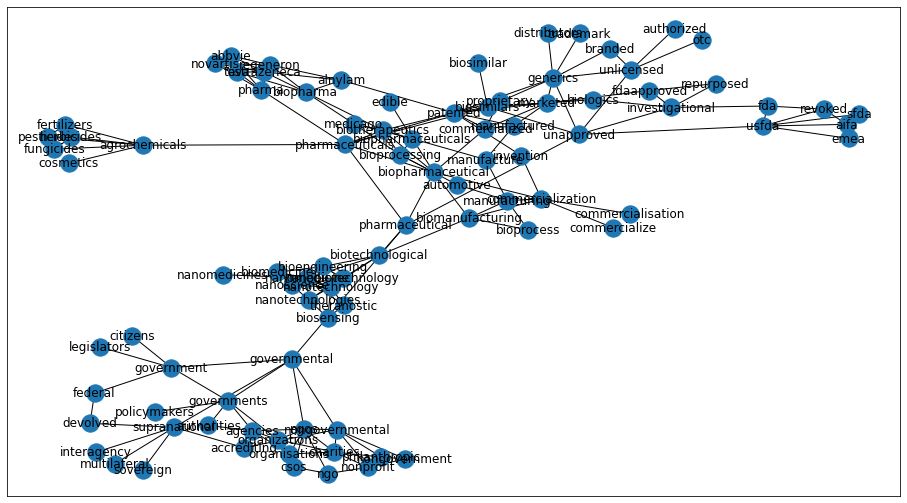

In [ ]:
# 4 levels deep knowledge graph with degree greater than 6 for the keyword "pharmaceutical"
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


words = pd.read_csv('/content/drive/MyDrive/similar_words_assignment3.csv')
g = nx.cubical_graph()

words1 = words[0:155]

#Construct the graph
#for every source word(node), add edges - connected through similarity
#As there two levels of similar words, we need to repeat the same to construct the graph
for i, row in words1.iterrows():
   
    for j in range(1,len(row)):
        g.add_node(row[j])
    for j in range(1,len(row)):
        g.add_edge(row[1], row[j])    
    
nx.draw_networkx(g)
plt.show()       
      
G = nx.petersen_graph()
options = {
    'node_color': 'blue',
    'node_size': 8,
    'line_color': 'blue',
    'linewidths': 0.3,
    'width': 0.5,
    'font_size':6,
}


#make sure to filter nodes based on the degree of connectivity
#and pick up nodes that are well connected. The number of connected concepts can be tuned using 
#the filter given below

fedges = filter(lambda x: g.degree()[x[0]] > 6 and g.degree()[x[1]] > 6, g.edges())
f = nx.Graph()                                                                                                                                     
f.add_edges_from(fedges)

#This is to show how well the keyword is connected with the other words in the corpus  
#change the keyword to obtain a different graph
#you do not need this while running the entire no
plt.rcParams['figure.figsize'] = [16, 9]

nx.draw_networkx(f)
plt.show()


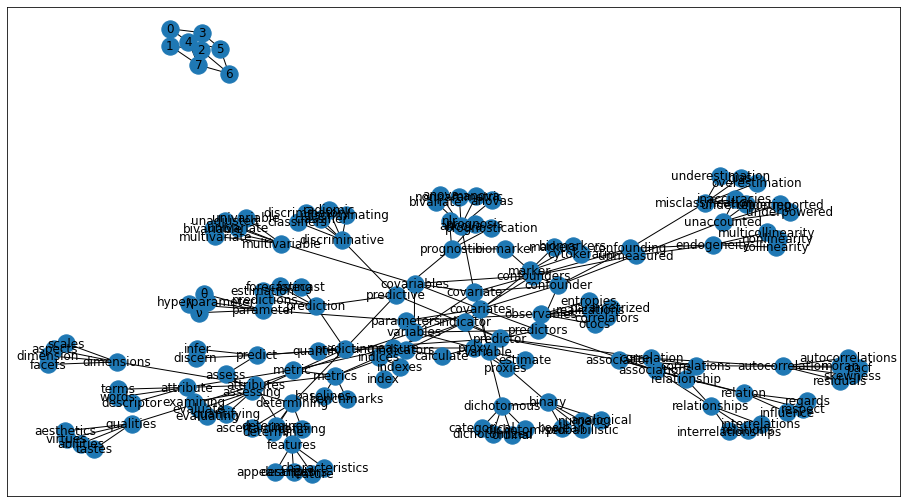

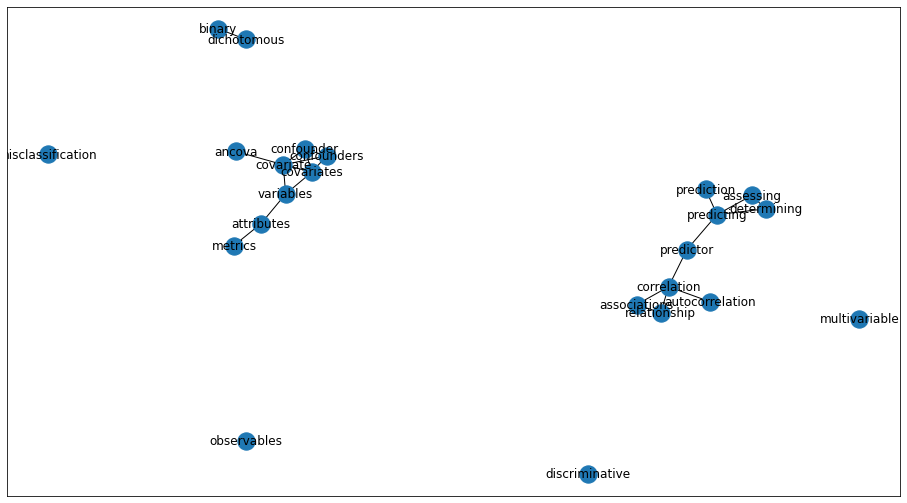

In [ ]:
# 4 levels deep knowledge graph with degree greater than 7 for the keyword "Predictors"


words = pd.read_csv('/content/drive/MyDrive/similar_words_assignment3.csv')
g = nx.cubical_graph()

words1 = words[1404:1560]

#Construct the graph
#for every source word(node), add edges - connected through similarity
#As there two levels of similar words, we need to repeat the same to construct the graph
for i, row in words1.iterrows():
   
    for j in range(1,len(row)):
        g.add_node(row[j])
    for j in range(1,len(row)):
        g.add_edge(row[1], row[j])    
    
nx.draw_networkx(g)
plt.show()       
      
G = nx.petersen_graph()
options = {
    'node_color': 'blue',
    'node_size': 8,
    'line_color': 'blue',
    'linewidths': 0.3,
    'width': 0.5,
    'font_size':6,
}


#make sure to filter nodes based on the degree of connectivity
#and pick up nodes that are well connected. The number of connected concepts can be tuned using 
#the filter given below

fedges = filter(lambda x: g.degree()[x[0]] > 7 and g.degree()[x[1]] > 7, g.edges())
f = nx.Graph()                                                                                                                                     
f.add_edges_from(fedges)

#This is to show how well the keyword is connected with the other words in the corpus  
#change the keyword to obtain a different graph
#you do not need this while running the entire no
plt.rcParams['figure.figsize'] = [16, 9]

nx.draw_networkx(f)
plt.show()

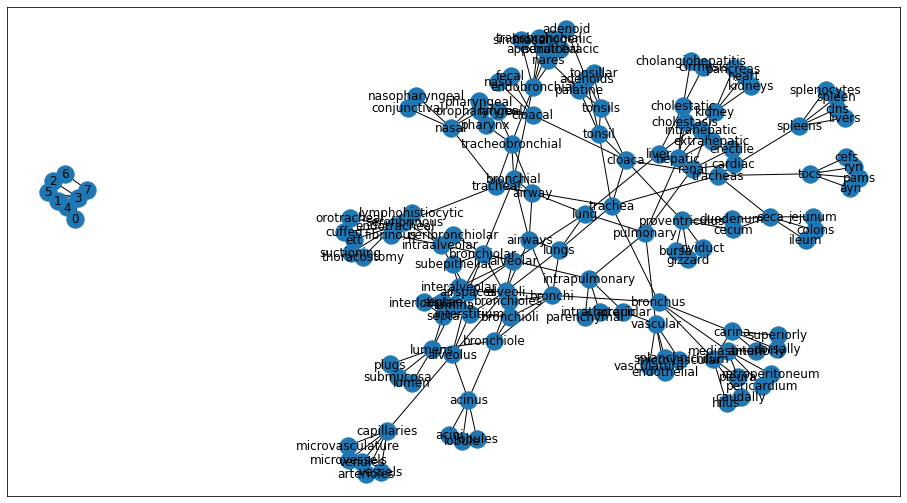

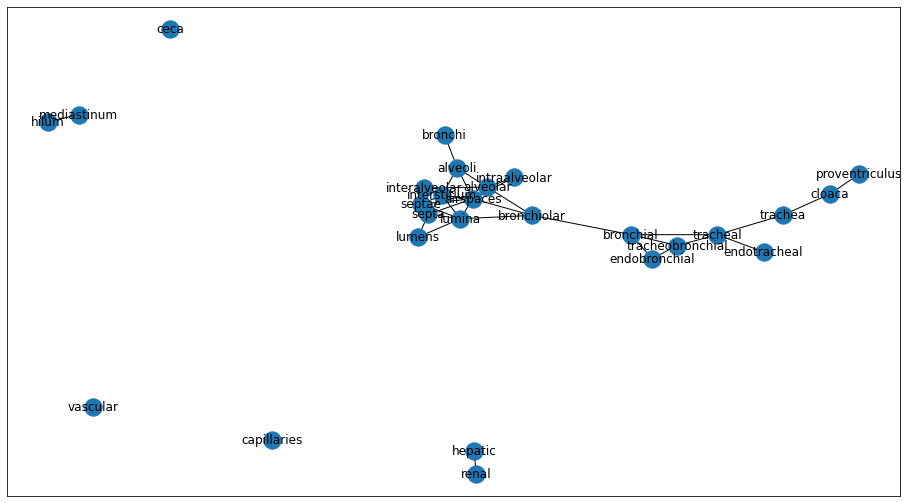

In [ ]:
# 4 levels deep knowledge graph with degree greater than 7 for the keyword "lungs"


words = pd.read_csv('/content/drive/MyDrive/similar_words_assignment3.csv')
g = nx.cubical_graph()

words1 = words[936:1092]

#Construct the graph
#for every source word(node), add edges - connected through similarity
#As there two levels of similar words, we need to repeat the same to construct the graph
for i, row in words1.iterrows():
   
    for j in range(1,len(row)):
        g.add_node(row[j])
    for j in range(1,len(row)):
        g.add_edge(row[1], row[j])    
    
nx.draw_networkx(g)
plt.show()       
      
G = nx.petersen_graph()
options = {
    'node_color': 'blue',
    'node_size': 8,
    'line_color': 'blue',
    'linewidths': 0.3,
    'width': 0.5,
    'font_size':6,
}


#make sure to filter nodes based on the degree of connectivity
#and pick up nodes that are well connected. The number of connected concepts can be tuned using 
#the filter given below

fedges = filter(lambda x: g.degree()[x[0]] > 7 and g.degree()[x[1]] > 7, g.edges())
f = nx.Graph()                                                                                                                                     
f.add_edges_from(fedges)

#This is to show how well the keyword is connected with the other words in the corpus  
#change the keyword to obtain a different graph
#you do not need this while running the entire no
plt.rcParams['figure.figsize'] = [16, 9]

nx.draw_networkx(f)
plt.show()

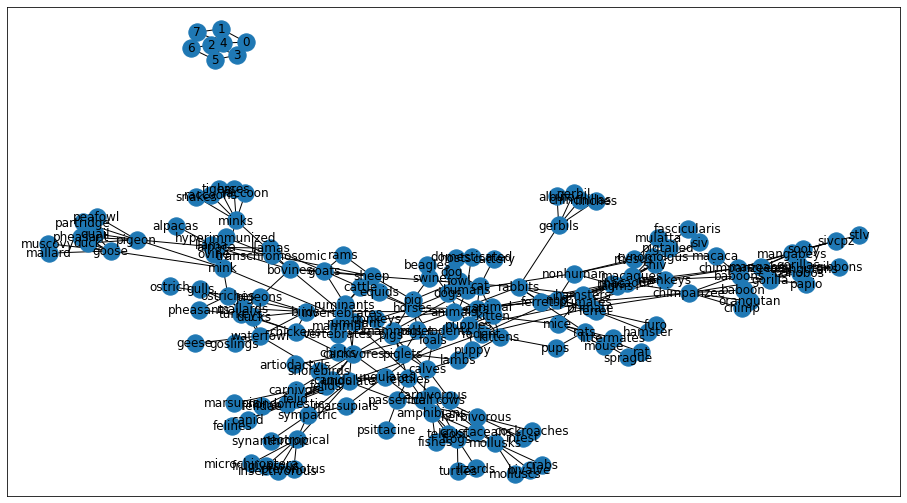

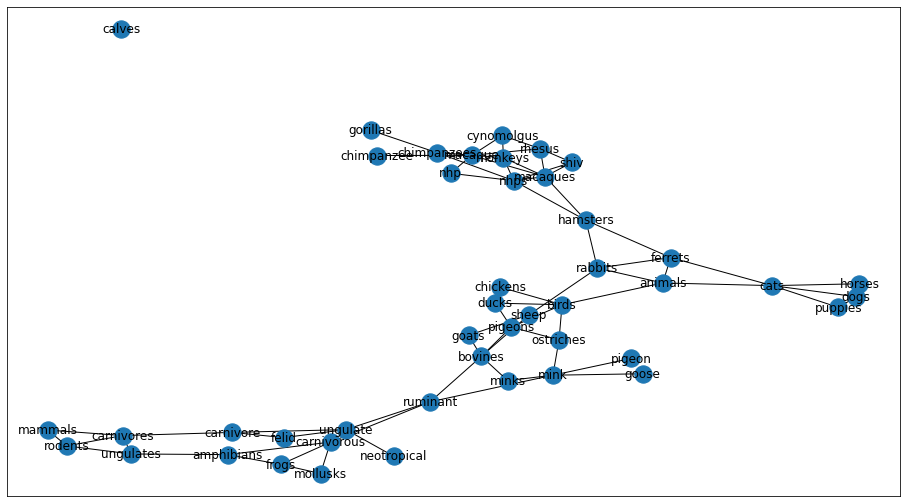

In [ ]:
# 4 levels deep knowledge graph with degree greater than 7 for the keyword "animal"


words = pd.read_csv('/content/drive/MyDrive/similar_words_assignment3.csv')
g = nx.cubical_graph()

words1 = words[156:312]

#Construct the graph
#for every source word(node), add edges - connected through similarity
#As there two levels of similar words, we need to repeat the same to construct the graph
for i, row in words1.iterrows():
   
    for j in range(1,len(row)):
        g.add_node(row[j])
    for j in range(1,len(row)):
        g.add_edge(row[1], row[j])    
    
nx.draw_networkx(g)
plt.show()       
      
G = nx.petersen_graph()
options = {
    'node_color': 'blue',
    'node_size': 8,
    'line_color': 'blue',
    'linewidths': 0.3,
    'width': 0.5,
    'font_size':6,
}


#make sure to filter nodes based on the degree of connectivity
#and pick up nodes that are well connected. The number of connected concepts can be tuned using 
#the filter given below

fedges = filter(lambda x: g.degree()[x[0]] > 7 and g.degree()[x[1]] > 7, g.edges())
f = nx.Graph()                                                                                                                                     
f.add_edges_from(fedges)

#This is to show how well the keyword is connected with the other words in the corpus  
#change the keyword to obtain a different graph
#you do not need this while running the entire no
plt.rcParams['figure.figsize'] = [16, 9]

nx.draw_networkx(f)
plt.show()